<a href="https://colab.research.google.com/github/kridtapon/WFO-Zero-Line-Harmony/blob/main/WFO_Zero_Line_Harmony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate the Trix Indicator
def calculate_trix(data, period):
    """
    Calculate the Trix (Triple Exponential Moving Average).
    """
    ema1 = data['Close'].ewm(span=period, min_periods=period).mean()
    ema2 = ema1.ewm(span=period, min_periods=period).mean()
    ema3 = ema2.ewm(span=period, min_periods=period).mean()
    trix = 100 * (ema3 - ema3.shift(1)) / ema3.shift(1)
    return trix

# Function to calculate the Detrended Price Oscillator (DPO)
def calculate_dpo(data, period):
    """
    Calculate the Detrended Price Oscillator (DPO).
    """
    sma = data['Close'].rolling(window=period).mean()
    dpo = data['Close'] - sma.shift(period // 2 + 1)
    return dpo

# Walk-forward optimization with Trix and DPO
def walk_forward_optimization(df, start_year, end_year):
    results = []

    # Define dynamic ranges for parameters
    trix_period_range = range(5, 31)
    dpo_period_range = range(5, 31)

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Use itertools to loop through all combinations dynamically
        for params in itertools.product(trix_period_range, dpo_period_range):
            trix_period, dpo_period = params

            # Calculate indicators on the training data
            train_data['Trix'] = calculate_trix(train_data, trix_period)
            train_data['DPO'] = calculate_dpo(train_data, dpo_period)

            # Generate entry and exit signals
            entries = (train_data['Trix'] > 0) & (train_data['DPO'] > 0)
            exits = (train_data['Trix'] < 0) & (train_data['DPO'] < 0)

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (trix_period, dpo_period)

        # Test with the best parameters on the test data
        test_data['Trix'] = calculate_trix(test_data, best_params[0])
        test_data['DPO'] = calculate_dpo(test_data, best_params[1])

        entries = (test_data['Trix'] > 0) & (test_data['DPO'] > 0)
        exits = (test_data['Trix'] < 0) & (test_data['DPO'] < 0)

        portfolio = vbt.Portfolio.from_signals(
            close=test_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'TRGP'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']
    yearly_data = df[df.index.year == year]

    # Apply Trix and DPO indicators
    yearly_data['Trix'] = calculate_trix(yearly_data, params[0])
    yearly_data['DPO'] = calculate_dpo(yearly_data, params[1])

    # Define entry/exit conditions
    entries = (yearly_data['Trix'] > 0) & (yearly_data['DPO'] > 0)
    exits = (yearly_data['Trix'] < 0) & (yearly_data['DPO'] < 0)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-53f30c714444>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-53f30c714444>:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-53f30c714444>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year Best_Params
0  2020      (9, 8)
1  2021     (6, 16)
2  2022     (6, 16)
3  2023     (5, 11)
4  2024     (7, 16)
5  2025      (9, 6)
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                          1004143.174164
Total Return [%]                       904.143174
Benchmark Return [%]                   396.466096
Max Gross Exposure [%]                      100.0
Total Fees Paid                      25522.947055
Max Drawdown [%]                        38.646804
Max Drawdown Duration                       537.0
Total Trades                                   26
Total Closed Trades                            26
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]          

<ipython-input-4-53f30c714444>:121: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-53f30c714444>:122: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-53f30c714444>:121: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-53f30

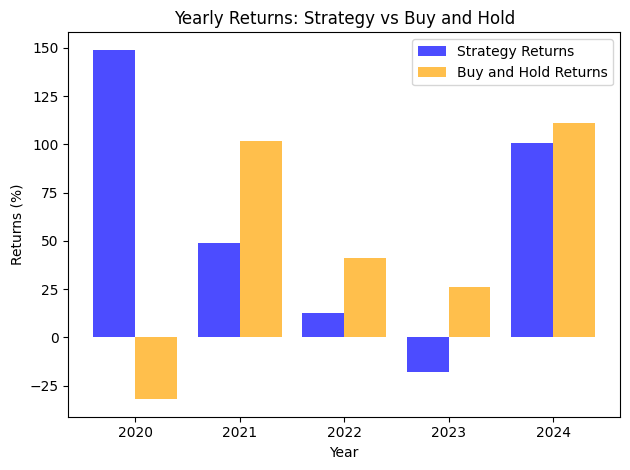

In [12]:
import matplotlib.pyplot as plt

# Calculate the buy-and-hold returns for each year
buy_and_hold_returns = []

for year in range(2020, 2025):
    yearly_data = df[df.index.year == year]
    if not yearly_data.empty:
        start_price = yearly_data['Close'].iloc[0]
        end_price = yearly_data['Close'].iloc[-1]
        buy_and_hold_return = (end_price - start_price) / start_price * 100
        buy_and_hold_returns.append(buy_and_hold_return)
    else:
        buy_and_hold_returns.append(0)

# Extract strategy returns for each year
strategy_returns = []

for year in range(2020, 2025):
    yearly_data = df[df.index.year == year]
    if not yearly_data.empty:
        entries = combined_entries[combined_entries.index.year == year]
        exits = combined_exits[combined_exits.index.year == year]

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )
        strategy_return = portfolio.total_return() * 100
        strategy_returns.append(strategy_return)
    else:
        strategy_returns.append(0)

# Plot the bar chart
years = list(range(2020, 2025))
bar_width = 0.4
x_indices = range(len(years))

plt.bar(x_indices, strategy_returns, width=bar_width, label='Strategy Returns', alpha=0.7, color='blue')
plt.bar([x + bar_width for x in x_indices], buy_and_hold_returns, width=bar_width, label='Buy and Hold Returns', alpha=0.7, color='orange')

# Formatting the chart
plt.xlabel('Year')
plt.ylabel('Returns (%)')
plt.title('Yearly Returns: Strategy vs Buy and Hold')
plt.xticks([x + bar_width / 2 for x in x_indices], years)
plt.legend()
plt.tight_layout()

# Display the chart
plt.show()
